<a href="https://colab.research.google.com/github/salonisuman06/Tesla_stockprice_prediction_using_tensorflow/blob/main/tesla_stock_price_prediction_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [61]:
df = pd.read_csv('/content/TSLA.csv')
print(df.shape)
df.head()

(2416, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [62]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

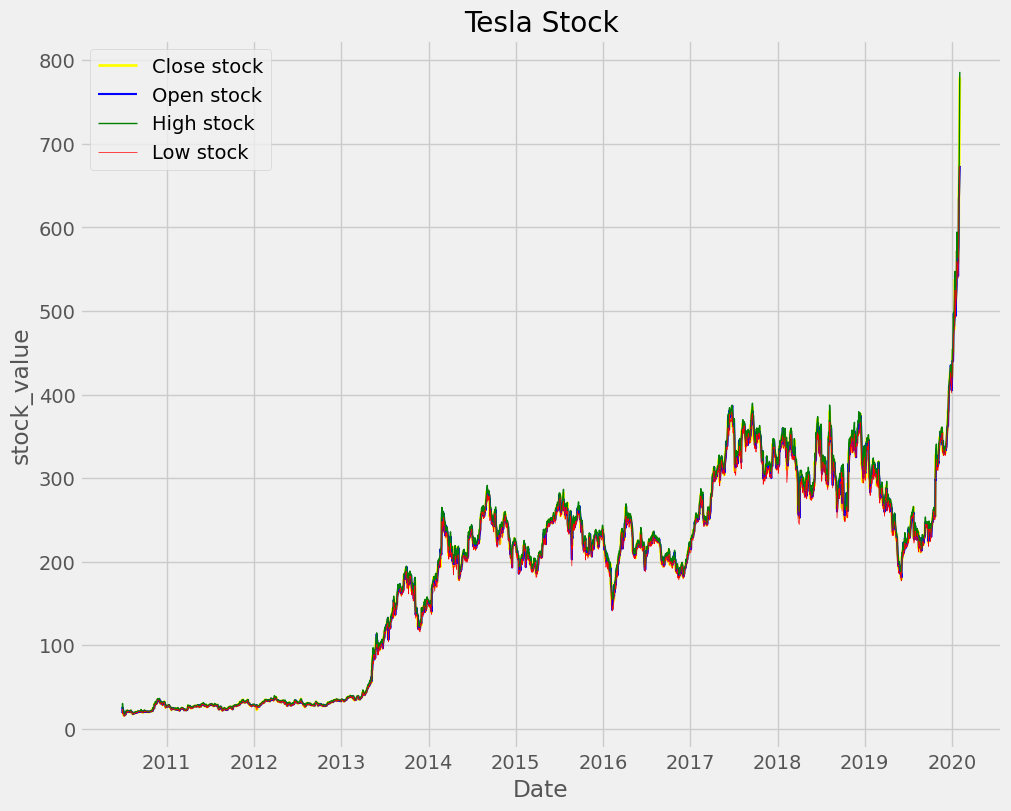

In [103]:
plt.figure(figsize=(10, 8),constrained_layout=True)
c = ['yellow', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [64]:
df2 = df[['High', 'Low', 'Open', 'Close']]
df2.head()

,High,Low,Open,Close
0,25.00,17.540001,19.000000,23.889999
1,30.42,23.299999,25.790001,23.830000
2,25.92,20.270000,25.000000,21.959999
3,23.10,18.709999,23.000000,19.200001
4,20.00,15.830000,20.000000,16.110001


In [65]:
def load_data(seq_len, series):
  x_data = []
  y_data = []

  for i in range(seq_len, len(series)):
    x = []
    y = []
    x.append([series['High'].iloc[i-seq_len: i].values])
    y.append(series['High'].iloc[i])
    x.append([series['Low'].iloc[i-seq_len: i].values])
    y.append(series['Low'].iloc[i])
    x.append([series['Open'].iloc[i-seq_len: i].values])
    y.append(series['Open'].iloc[i])
    x.append([series['Close'].iloc[i-seq_len: i].values])
    y.append(series['Close'].iloc[i])
    x_data.append(x)
    y_data.append(y)

  x_data_train = x_data[:int(0.9*(len(series)))]
  x_data_val = x_data[int(0.9*(len(series))):]


  y_data_train = y_data[:int(0.9*(len(series)))]
  y_data_val = y_data[int(0.9*(len(series))):]

  x_train = np.array(x_data_train)
  x_val = np.array(x_data_val)

  y_train = np.array(y_data_train)
  y_val = np.array(y_data_val)

  x_train = np.reshape(x_train, (x_train.shape[0], 4, seq_len))
  x_val = np.reshape(x_val, (x_val.shape[0], 4, seq_len))

  y_train = np.reshape(y_train, (y_train.shape[0], 1, 4))
  y_val = np.reshape(y_val, (y_val.shape[0], 1, 4))

  x_full = np.array(x_data)
  x_full = np.reshape(x_full, (x_full.shape[0], 4, seq_len))

  y_full = np.array(y_data)
  y_full = np.reshape(y_full, (y_full.shape[0], 1, 4))

  return (x_train, x_val, y_train, y_val, x_full, y_full)


In [66]:
(x_train, x_val, y_train, y_val, x_full, y_full) = load_data(64, df2)

In [67]:
print(f'the shape of all x_train is {x_train.shape}\n\
the shape of all y_train is {y_train.shape}\n\
the shape of all x_val is {x_val.shape}\n\
the shape of all y_val is {y_val.shape}')

the shape of all x_train is (2174, 4, 64)
the shape of all y_train is (2174, 1, 4)
the shape of all x_val is (178, 4, 64)
the shape of all y_val is (178, 1, 4)


In [68]:
print(f'the shape of full x is {x_full.shape}\n\
the shape of full y is {y_full.shape}')

the shape of full x is (2352, 4, 64)
the shape of full y is (2352, 1, 4)


In [69]:
def make_dataset(x, y, buffer_size=1000, batch_size=150):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    data = data.cache().shuffle(buffer_size).batch(batch_size)
    return data

In [70]:
train_dataset = make_dataset(x_train, y_train)
val_dataset = make_dataset(x_val, y_val)

In [71]:
def base_model(inputs):
  x = Conv1D(filters=128,kernel_size=4, activation='relu', name='conv_1D')(inputs)
  x = Bidirectional(LSTM(units=64, return_sequences=True, name='b_lstm_1'))(x)
  x = ks.layers.Dropout(0.2)(x)
  x = Bidirectional(LSTM(units=64, return_sequences=True, name='b_lstm_2'))(x)
  x = ks.layers.Dropout(0.2)(x)
  x = LSTM(units=32, return_sequences=True, name='lstm_3')(x)
  return x

def final_model(inputs):
  x = base_model(inputs)
  x = Dense(units=128, activation='relu', name='dense_1')(inputs)
  x = Dense(units=64, name='dense_2')(x)
  x = Lambda(lambda x:x*16, name='lambda_1')(x)
  high_stock = Dense(1, name='high_stock')(x)
  low_stock = Dense(1, name='low_stock')(x)
  open_stock = Dense(1, name='open_stock')(x)
  close_stock = Dense(1, name='close_stock')(x)

  model = Model(inputs=inputs, outputs=[high_stock, low_stock, open_stock, close_stock])
  return model
inputs =Input(shape=(4, 64, ))
model = final_model(inputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 64)]      0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 4, 128)       8320        ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 4, 64)        8256        ['dense_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 4, 64)        0           ['dense_2[0][0]']                
                                                                                              

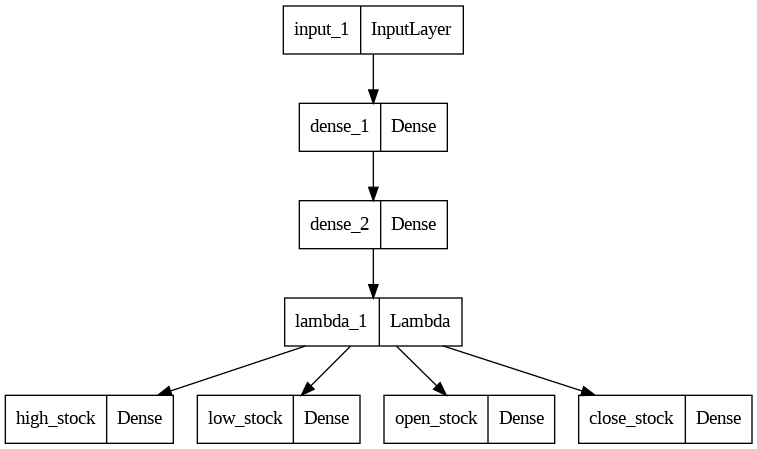

In [72]:
ks.utils.plot_model(model)

In [73]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch /22))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss={
    'high_stock': ks.losses.Huber(),
    'low_stock': ks.losses.Huber(),
    'open_stock': ks.losses.Huber(),
    'close_stock': ks.losses.Huber()
    },
     optimizer=optimizer,
     metrics={
         'high_stock': ['mae'],
        'low_stock': ['mae'],
        'open_stock': ['mae'],
        'close_stock': ['mae']
        })
history = model.fit(x=x_train, y=y_train, epochs=100, callbacks=[lr_schedule], verbose=0)

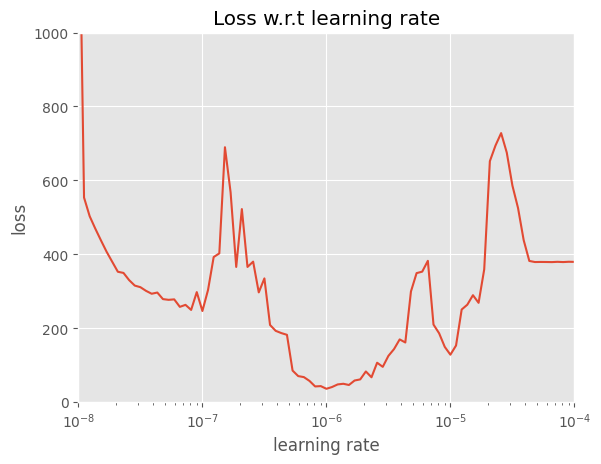

In [74]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 1000])
plt.title('Loss w.r.t learning rate')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.show()

In [75]:
model = final_model(inputs)
model.compile(loss={
    'high_stock': ks.losses.Huber(),
    'low_stock': ks.losses.Huber(),
    'open_stock': ks.losses.Huber(),
    'close_stock': ks.losses.Huber()
    },
     optimizer=ks.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
     metrics={
         'high_stock': ['mae'],
        'low_stock': ['mae'],
        'open_stock': ['mae'],
        'close_stock': ['mae']
        })
history = model.fit(x_train, y_train, epochs=1300, verbose=0)

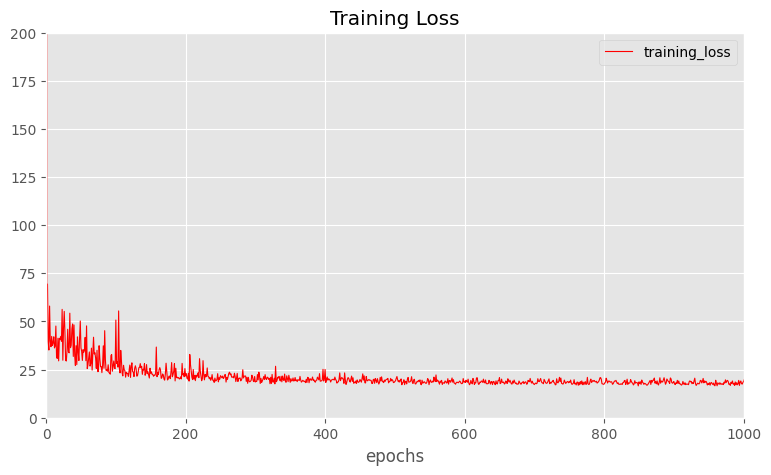

In [76]:
loss = history.history['loss']
epochs = range(len(loss))
plt.style.use('default')
plt.style.use('ggplot')
plt.figure(figsize=(9, 5))
#plt.plot(epochs[400:], mae, color='blue', label='trainig_mae')
plt.plot(epochs, loss, color='red', label='training_loss', linewidth=0.8)
plt.title('Training Loss')
plt.xlabel('epochs')
plt.xlim(0, 1000)
plt.ylim(0, 200)
plt.legend()
plt.show()

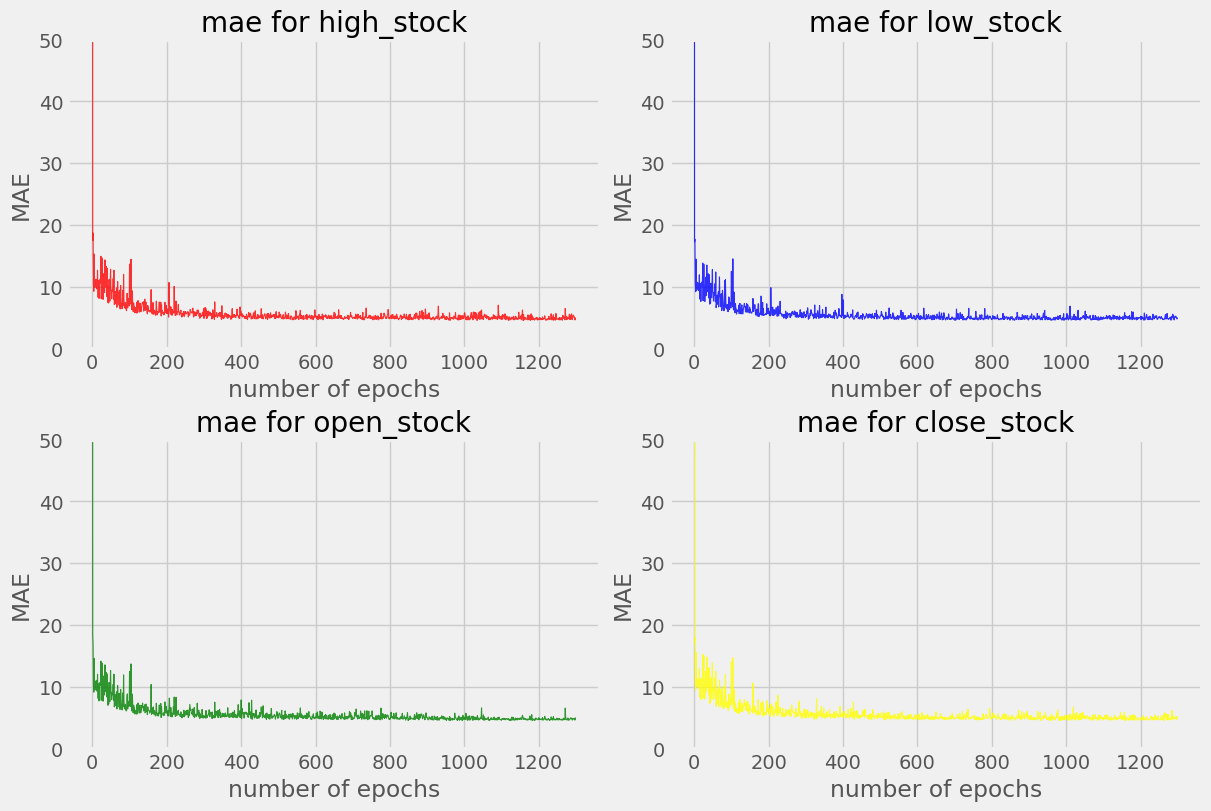

In [104]:
high_stock_mae = history.history['high_stock_mae']
low_stock_mae = history.history['low_stock_mae']
open_stock_mae = history.history['open_stock_mae']
close_stock_mae = history.history['close_stock_mae']
epochs = range(len(high_stock_mae))
result = []
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
spec = gridspec.GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax = [ax1, ax2, ax3, ax4]
stock = [high_stock_mae, low_stock_mae, open_stock_mae, close_stock_mae]
title_stock = ['mae for high_stock', 'mae for low_stock', 'mae for open_stock', 'mae for close_stock']
color = ['red', 'blue', 'green', 'yellow']
for i in range(4):
  ax[i].plot(epochs, stock[i], color=color[i], alpha=0.8, linewidth=0.8)
  ax[i].set_ylim(0, 50)
  ax[i].set_title(title_stock[i])
  ax[i].set_xlabel('number of epochs')
  ax[i].set_ylabel('MAE')

plt.show()

In [78]:
forecast = model.predict(x_val)
forecast = np.array(forecast)
forecast.shape

6/6 [==============================] - 0s 5ms/step


(4, 178, 4, 1)

In [79]:
def sep_target(data):
  high_hat = []
  low_hat = []
  open_hat = []
  close_hat = []
  for zeroth in data[0, :, :]:
    high_hat.append(zeroth[0][0])
    low_hat.append(zeroth[1][0])
    open_hat.append(zeroth[2][0])
    close_hat.append(zeroth[3][0])
  high_hat = np.array(high_hat)
  low_hat = np.array(low_hat)
  open_hat = np.array(open_hat)
  close_hat = np.array(close_hat)
  return (high_hat, low_hat, open_hat, close_hat)

In [84]:
high_preds, low_preds, open_preds, close_preds = sep_target(forecast)

In [85]:
def sep_ans(data):
  high_hat = []
  low_hat = []
  open_hat = []
  close_hat = []
  for zeroth in data[:, 0]:
    high_hat.append(zeroth[0])
    low_hat.append(zeroth[1])
    open_hat.append(zeroth[2])
    close_hat.append(zeroth[3])
  high_hat = np.array(high_hat)
  low_hat = np.array(low_hat)
  open_hat = np.array(open_hat)
  close_hat = np.array(close_hat)
  return (high_hat, low_hat, open_hat, close_hat)

In [86]:
high_real, low_real, open_real, close_real = sep_ans(y_val)

In [109]:
def plt_forecast(x, y, title):
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(30, 10))
  plt.plot(x, color='red', linewidth=1.2, label='predicted value')
  plt.plot(y, color='blue', linewidth=0.9, label='true value')
  plt.title(title, fontsize=40)
  plt.legend(fontsize=30)

  plt.show()

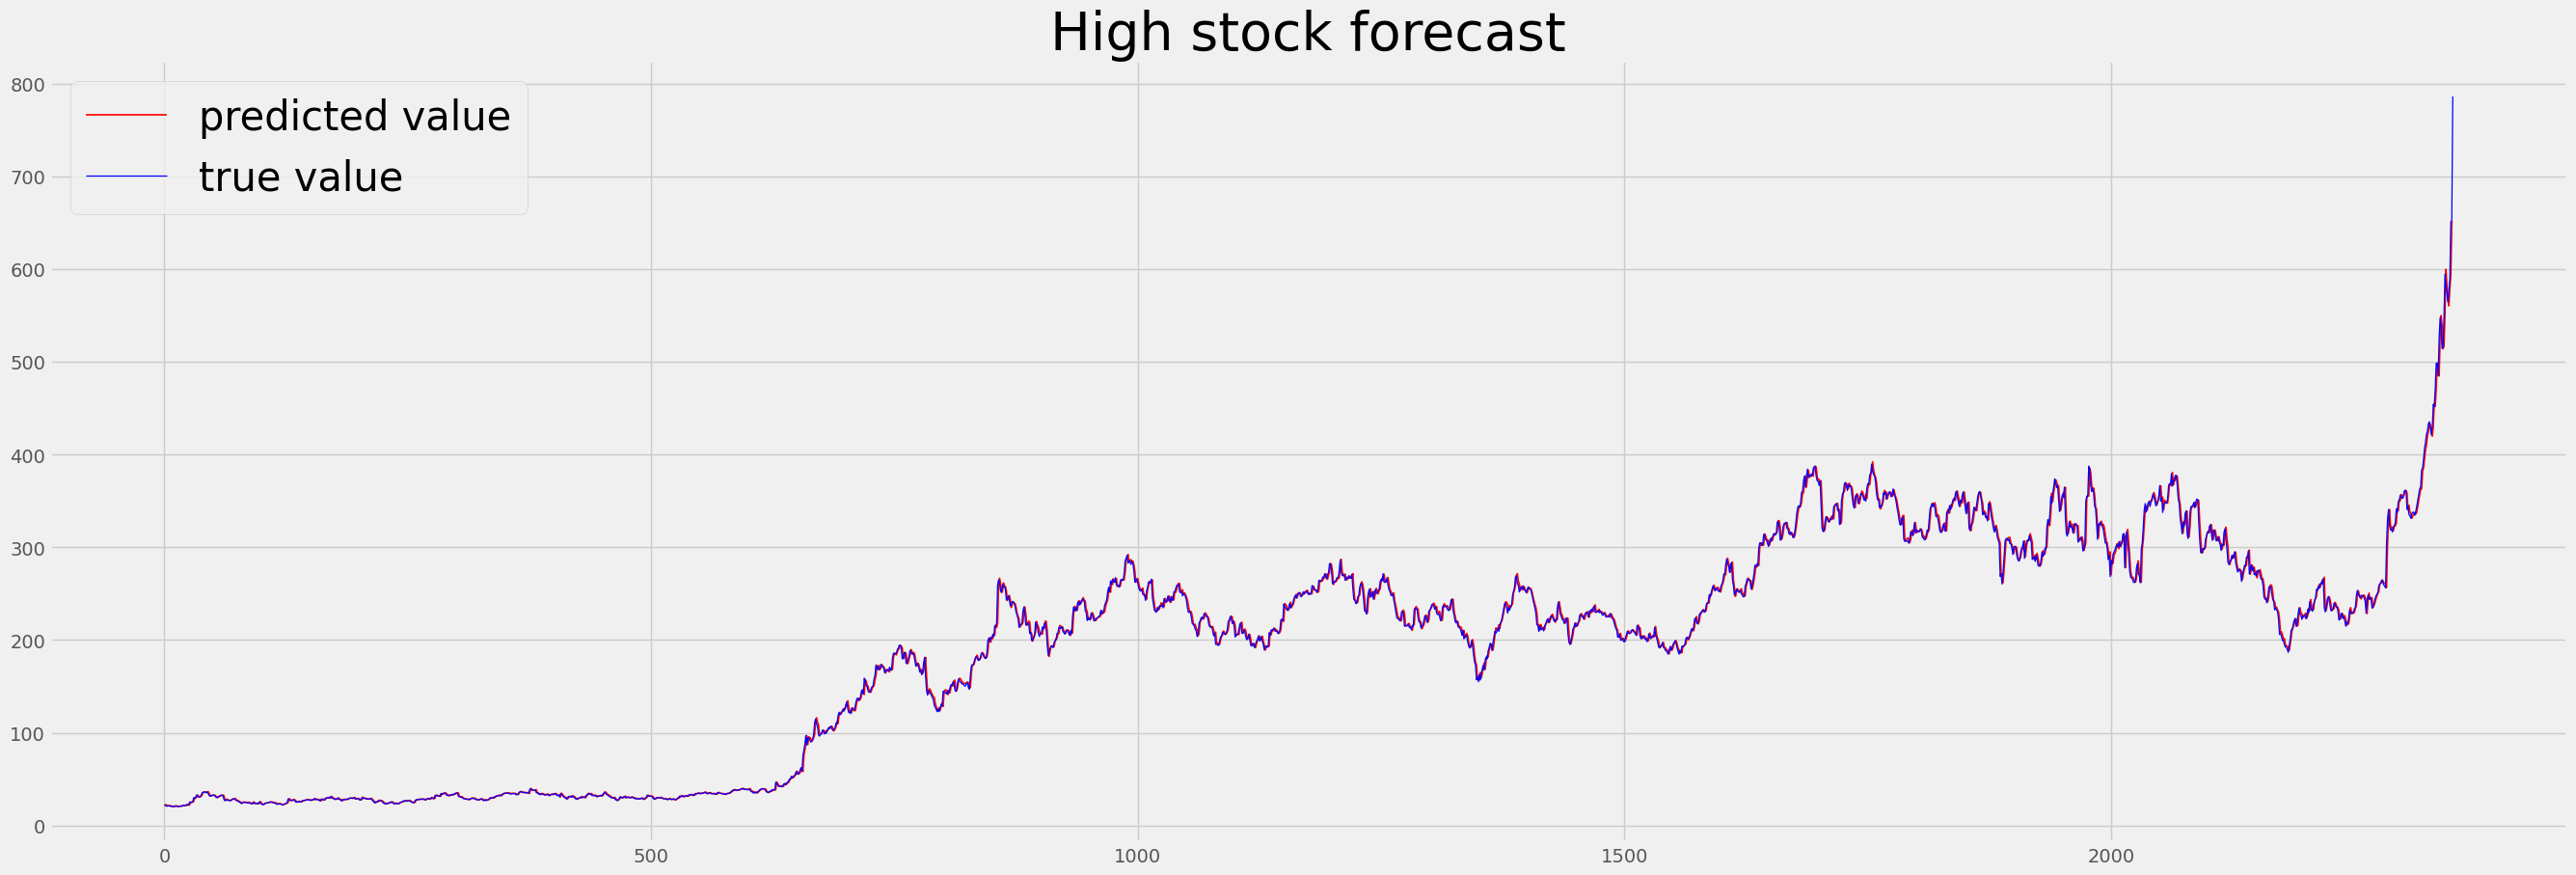

In [110]:
plt_forecast(high_preds, high_real, 'High stock forecast')

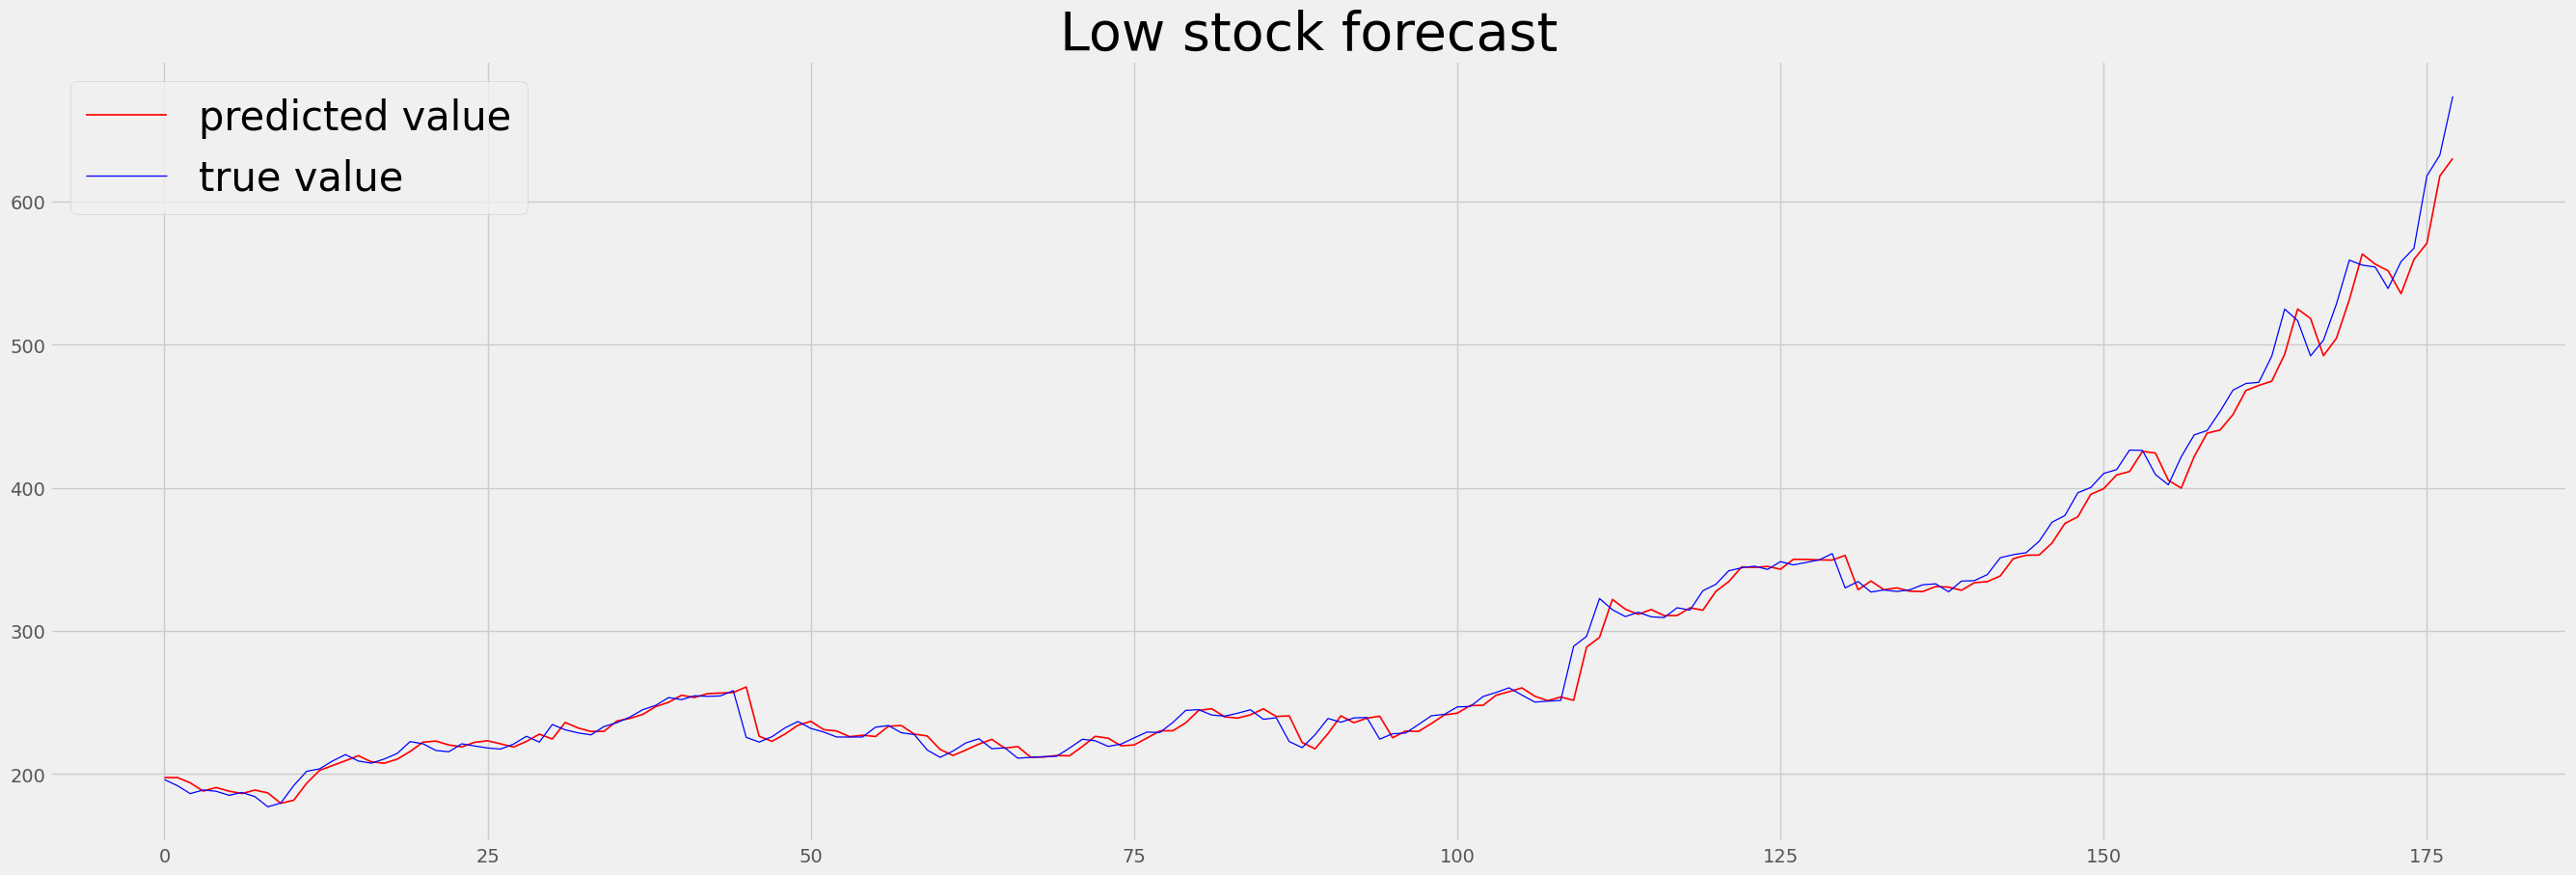

In [89]:
plt_forecast(low_preds, low_real, 'Low stock forecast')


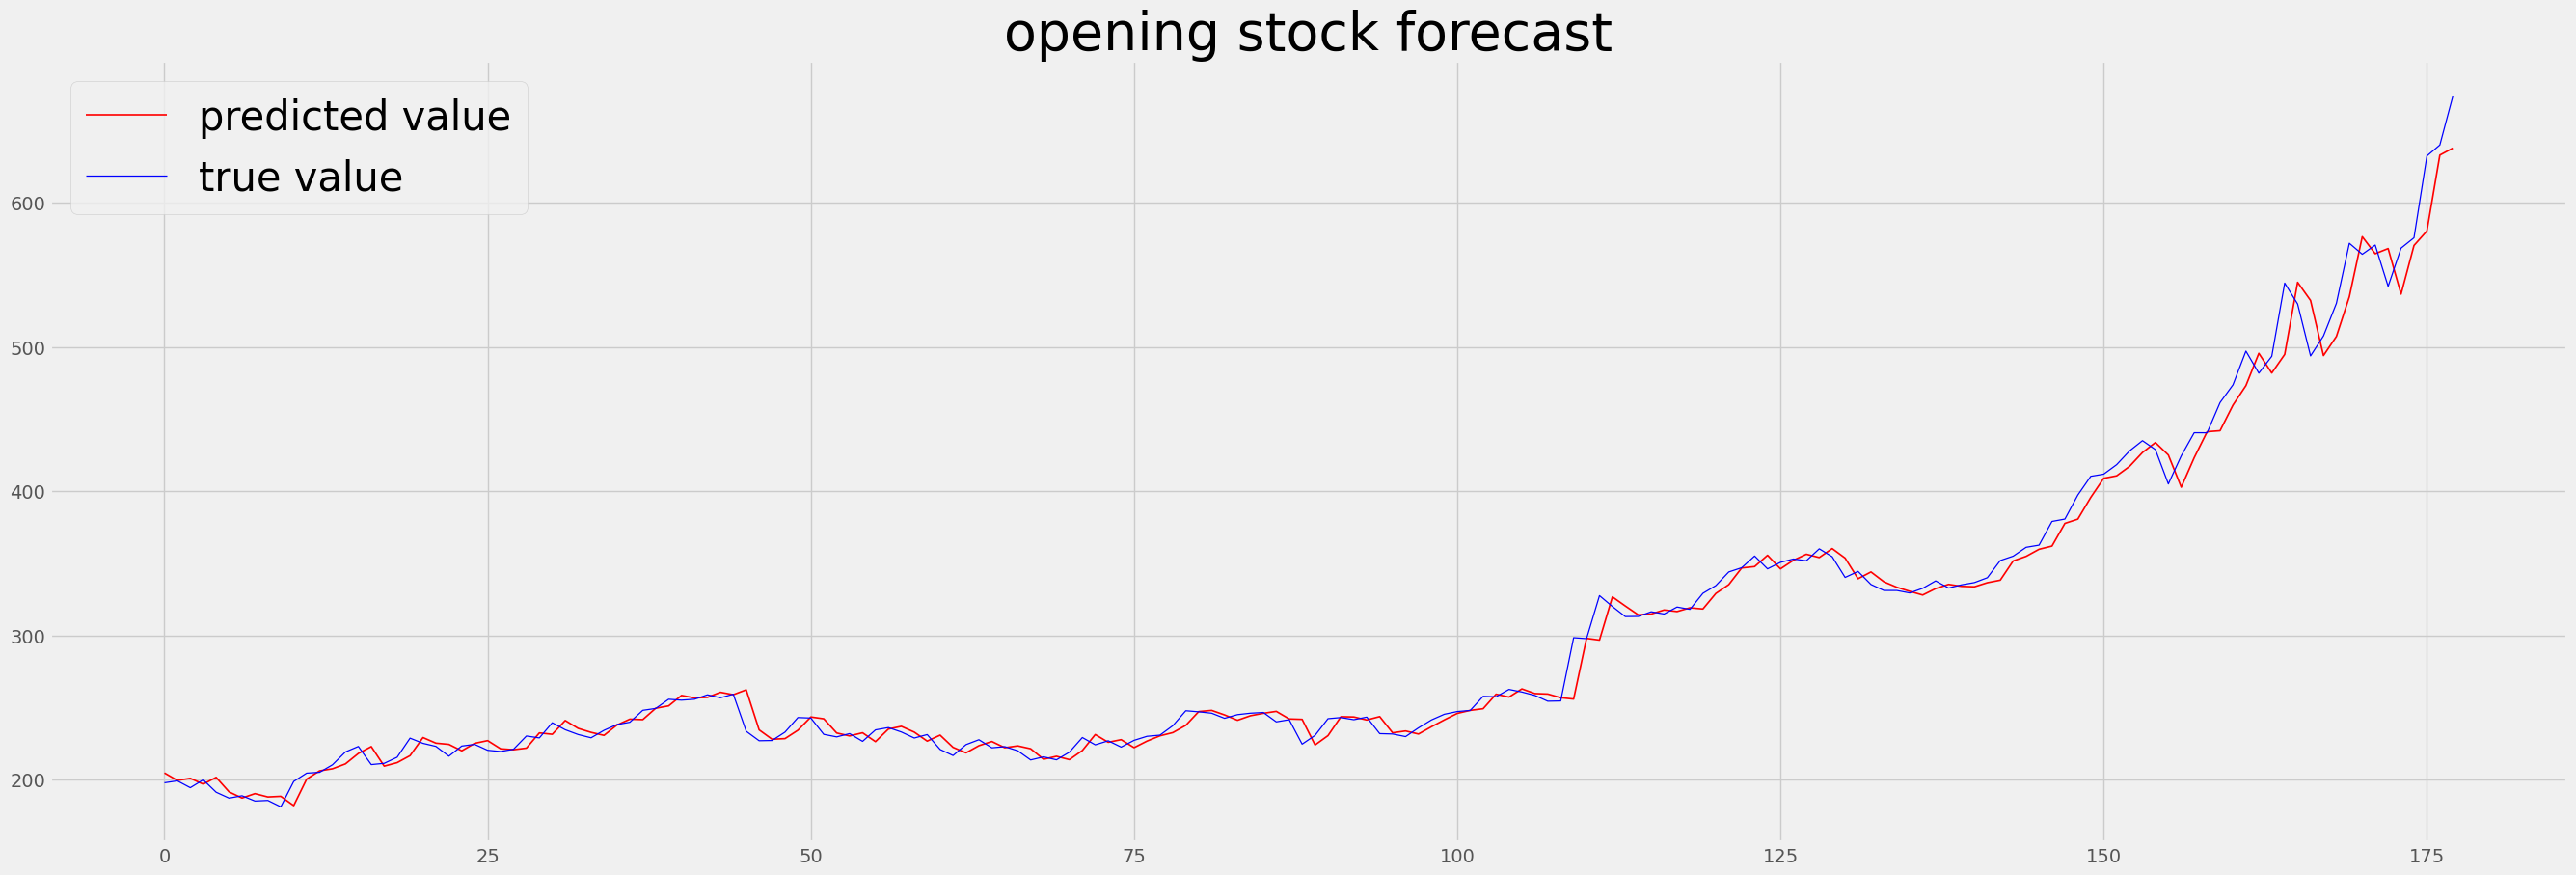

In [90]:
plt_forecast(open_preds, open_real, 'opening stock forecast')

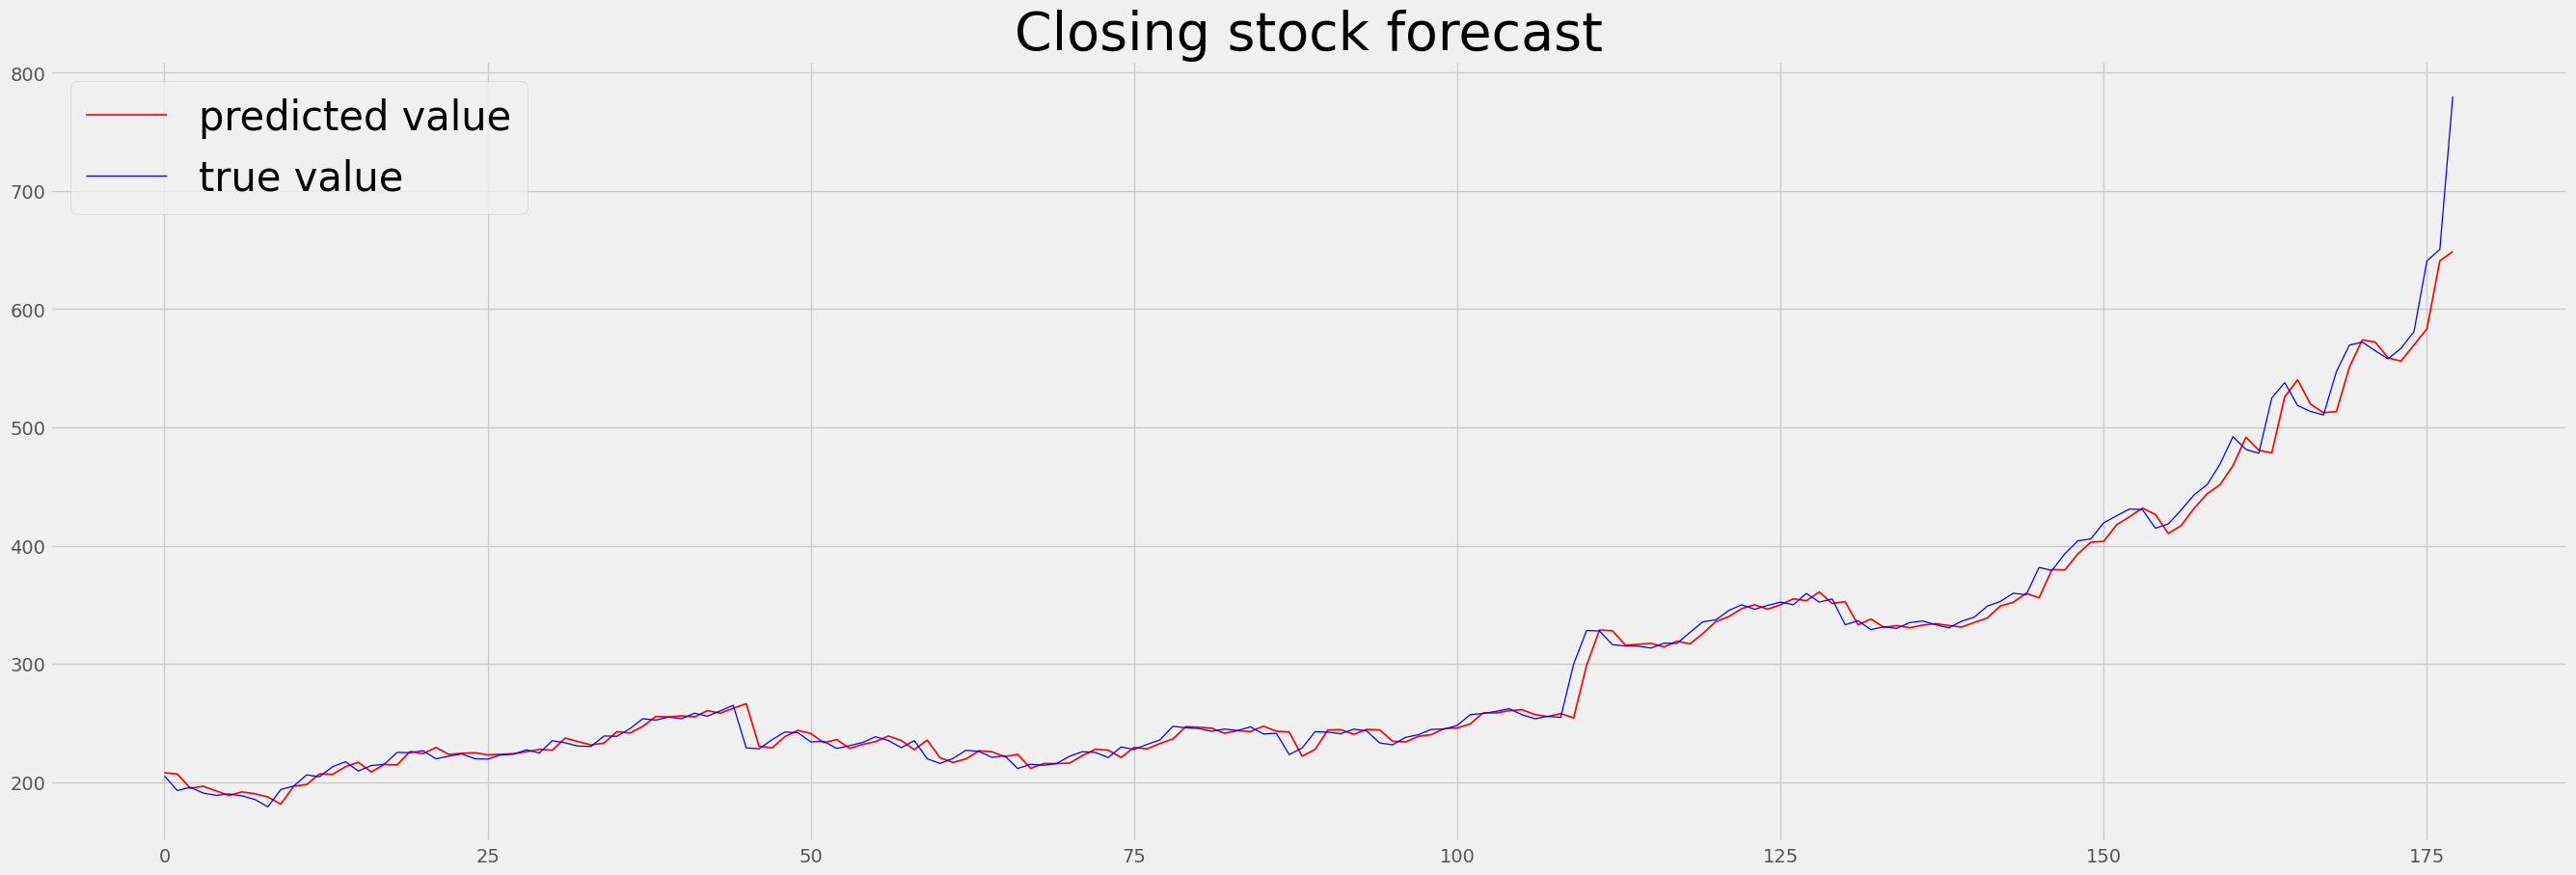

In [91]:
plt_forecast(close_preds, close_real, 'Closing stock forecast')

In [92]:
forecast_val = pd.DataFrame({
    'open': open_preds, 'close': close_preds, 'high': high_preds, 'low': low_preds
})

In [93]:
forecast_val.head(10)

,open,close,high,low
0,204.556366,207.815445,208.217056,197.437576
1,199.391739,206.679977,208.878296,197.443985
2,200.836960,194.685074,205.994064,193.750626
3,196.811935,196.331650,200.765656,187.946518
4,201.503464,192.466812,201.726349,190.487518
5,191.449844,188.594833,195.283615,187.908463
6,187.173309,191.612183,193.413910,186.279831
7,190.228210,190.035645,193.421310,188.692581
8,187.921295,187.288986,192.444870,186.685654
9,188.364517,181.239685,188.963028,179.433685


In [94]:
full_forecast = model.predict(x_full)
full_forecast = np.array(full_forecast)
full_forecast.shape

74/74 [==============================] - 0s 3ms/step


(4, 2352, 4, 1)

In [95]:
high_preds, low_preds, open_preds, close_preds = sep_target(full_forecast)

In [96]:
high_real, low_real, open_real, close_real = sep_ans(y_full)

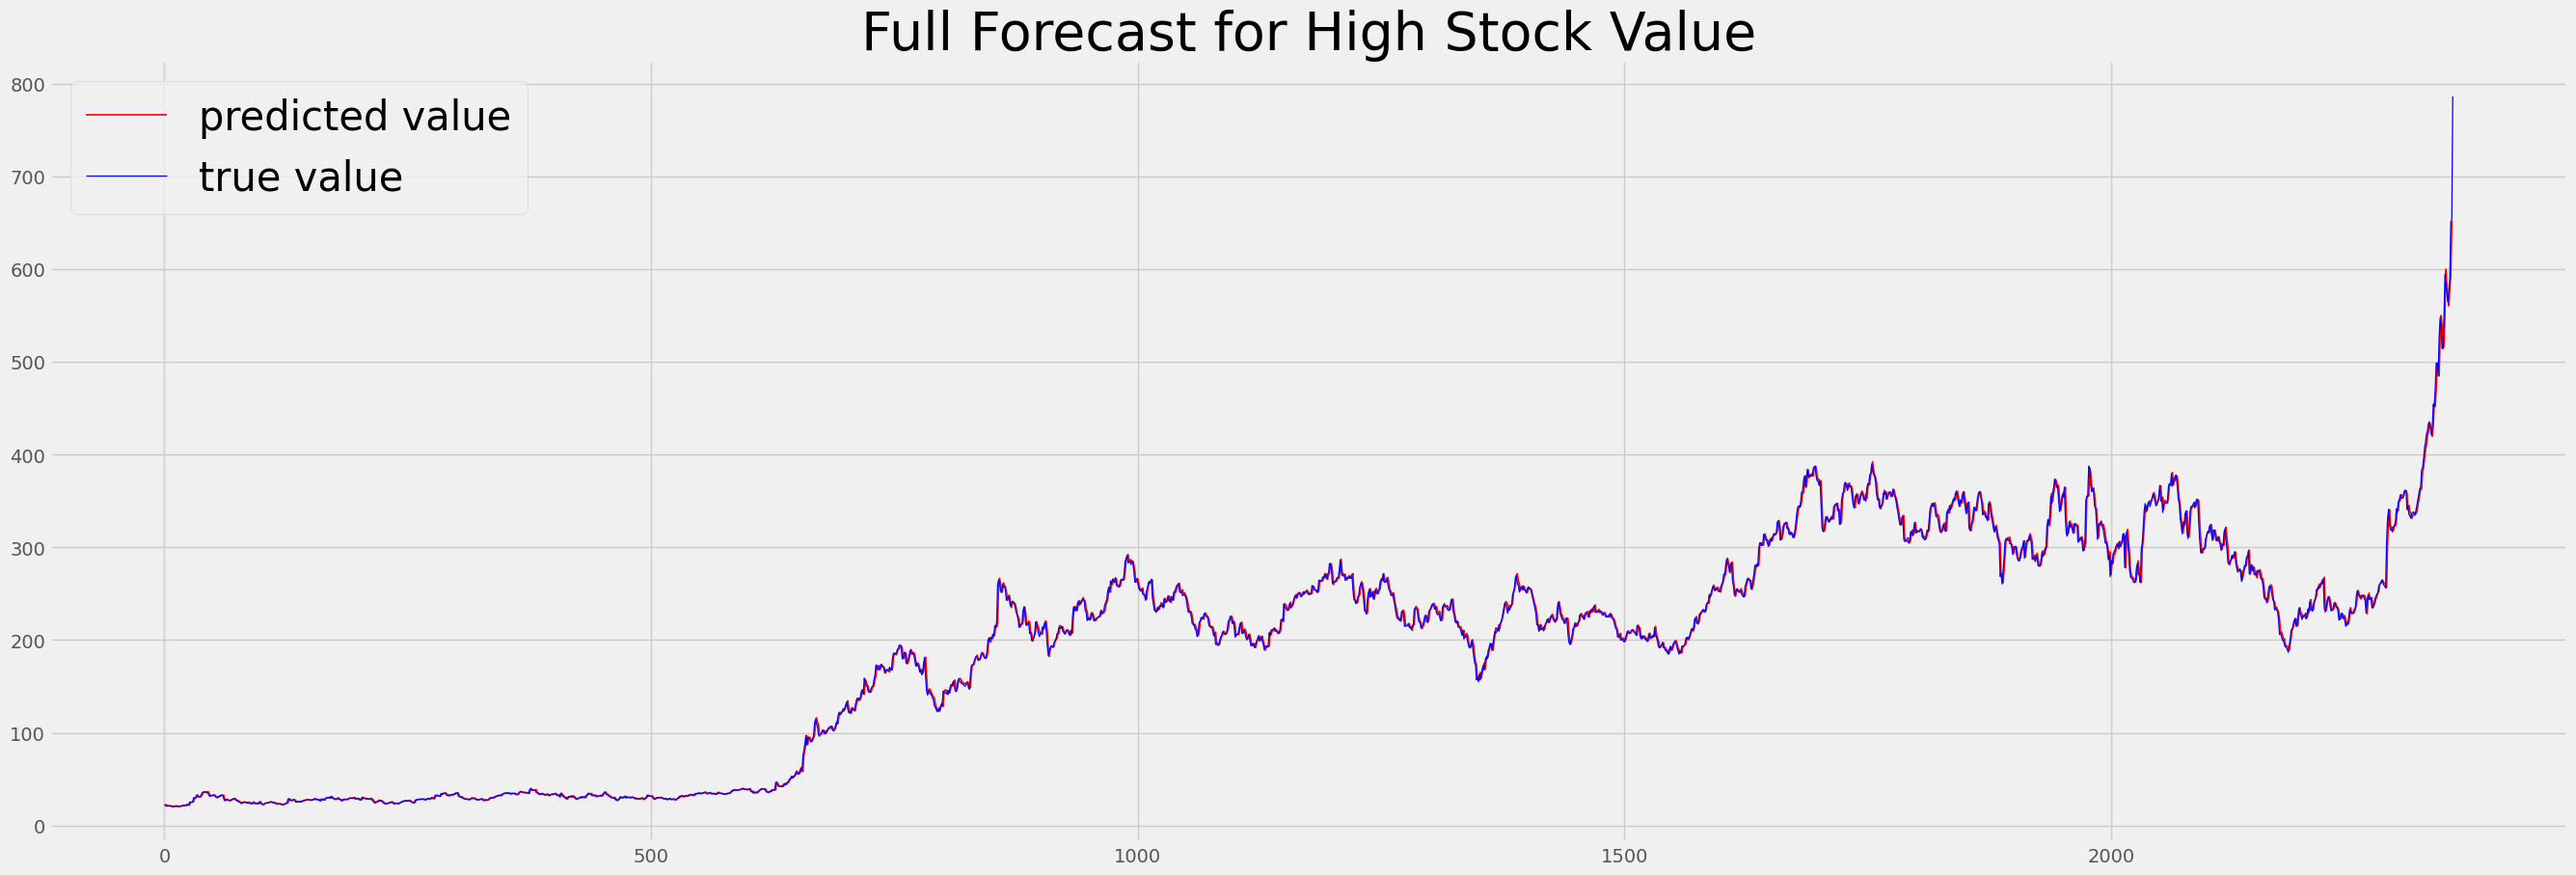

In [97]:
plt_forecast(high_preds, high_real, 'Full Forecast for High Stock Value')

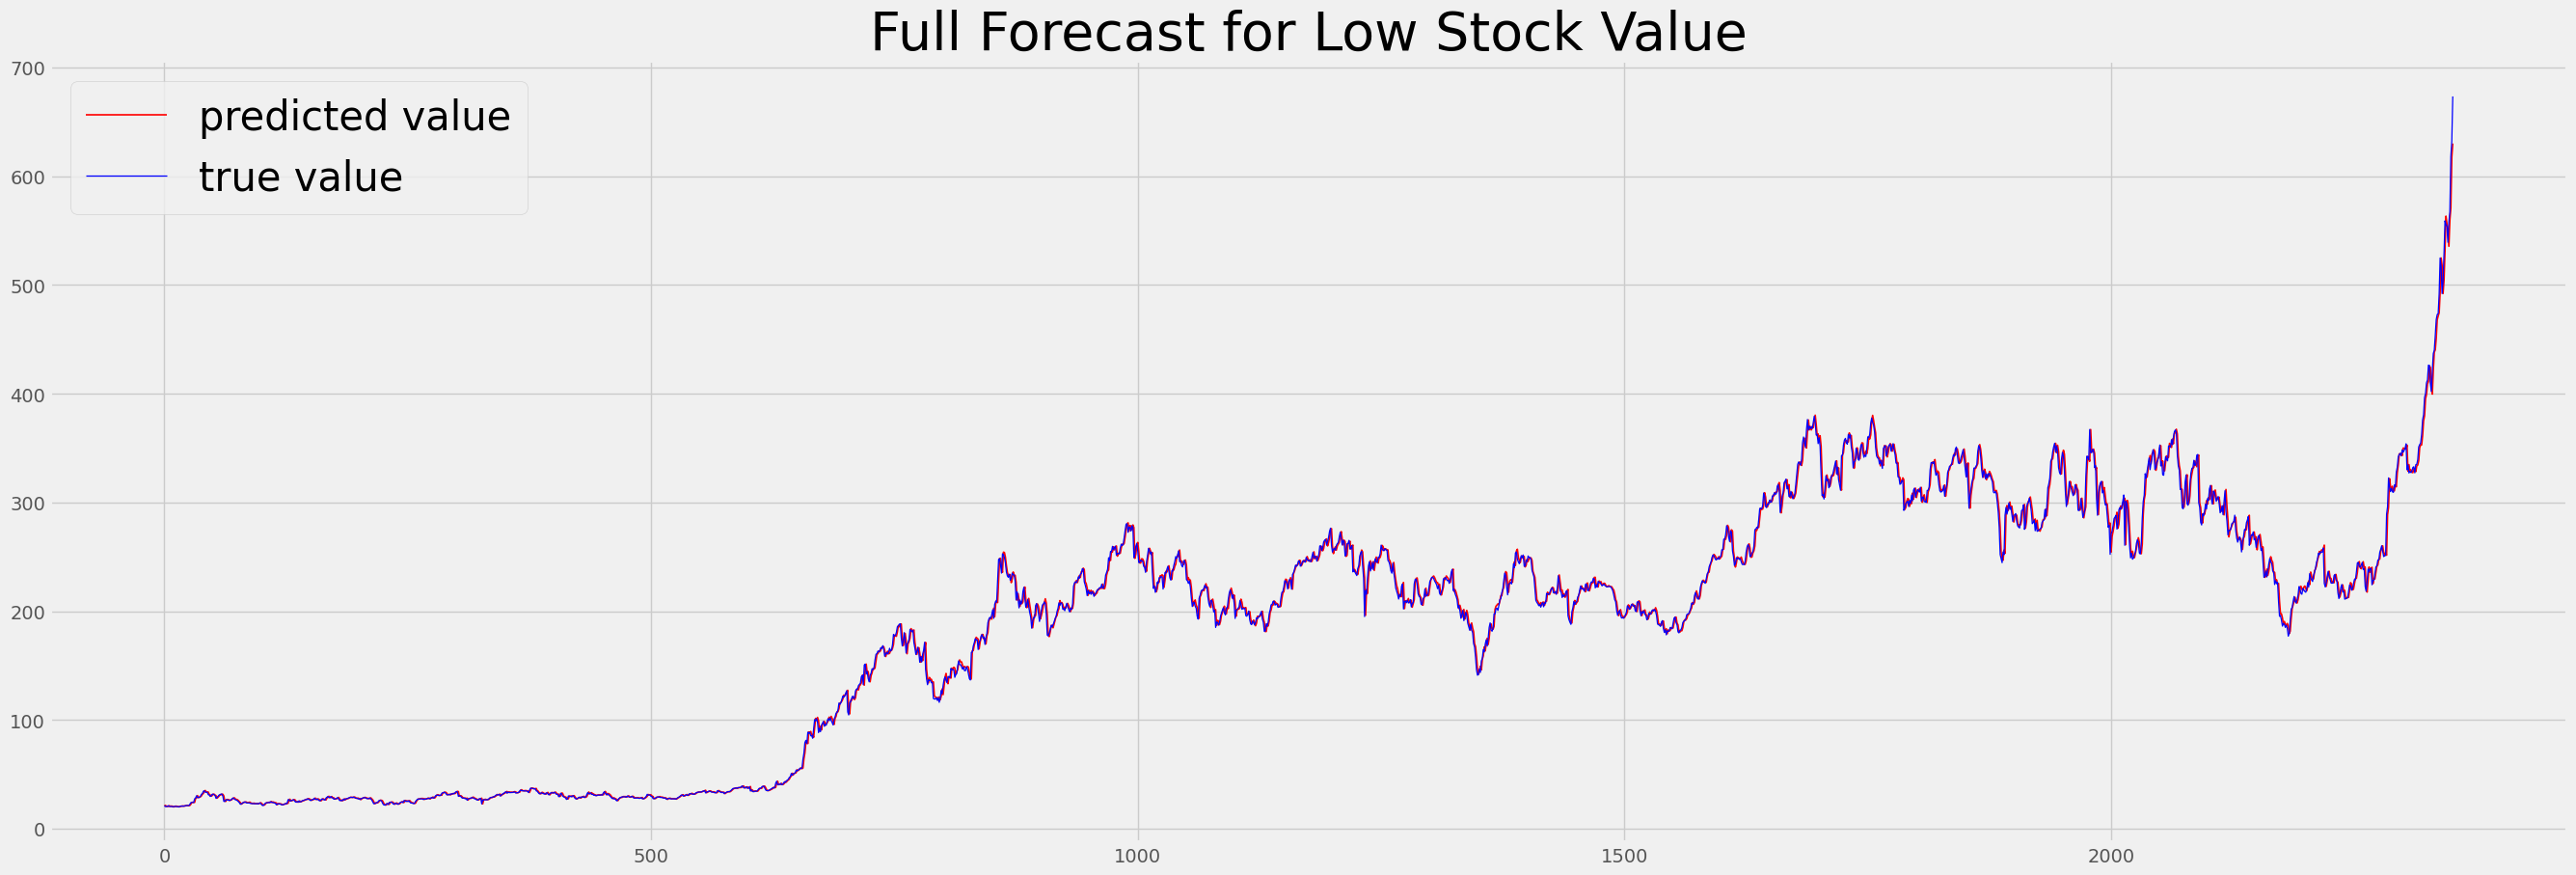

In [98]:
plt_forecast(low_preds, low_real, 'Full Forecast for Low Stock Value')

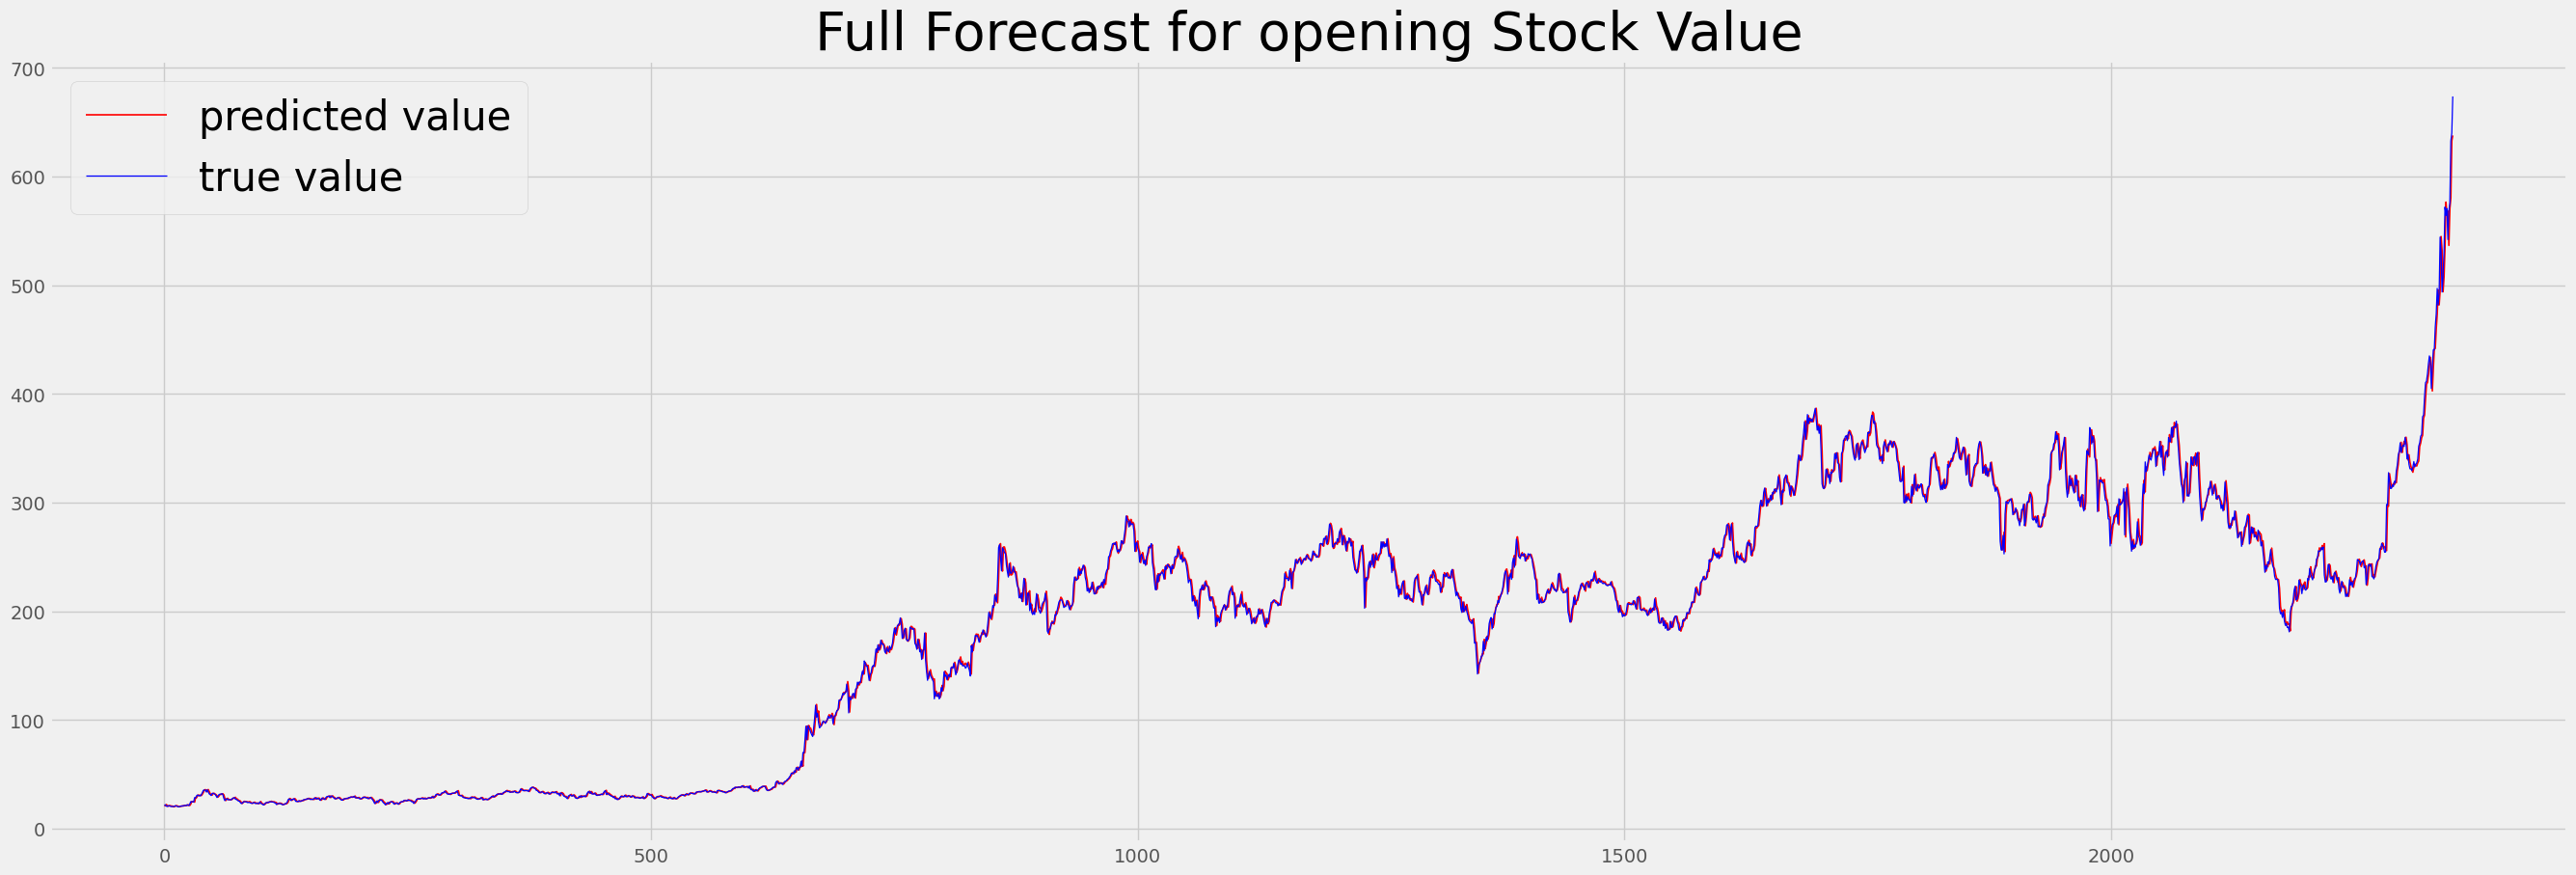

In [100]:
plt_forecast(open_preds, open_real, 'Full Forecast for opening Stock Value')

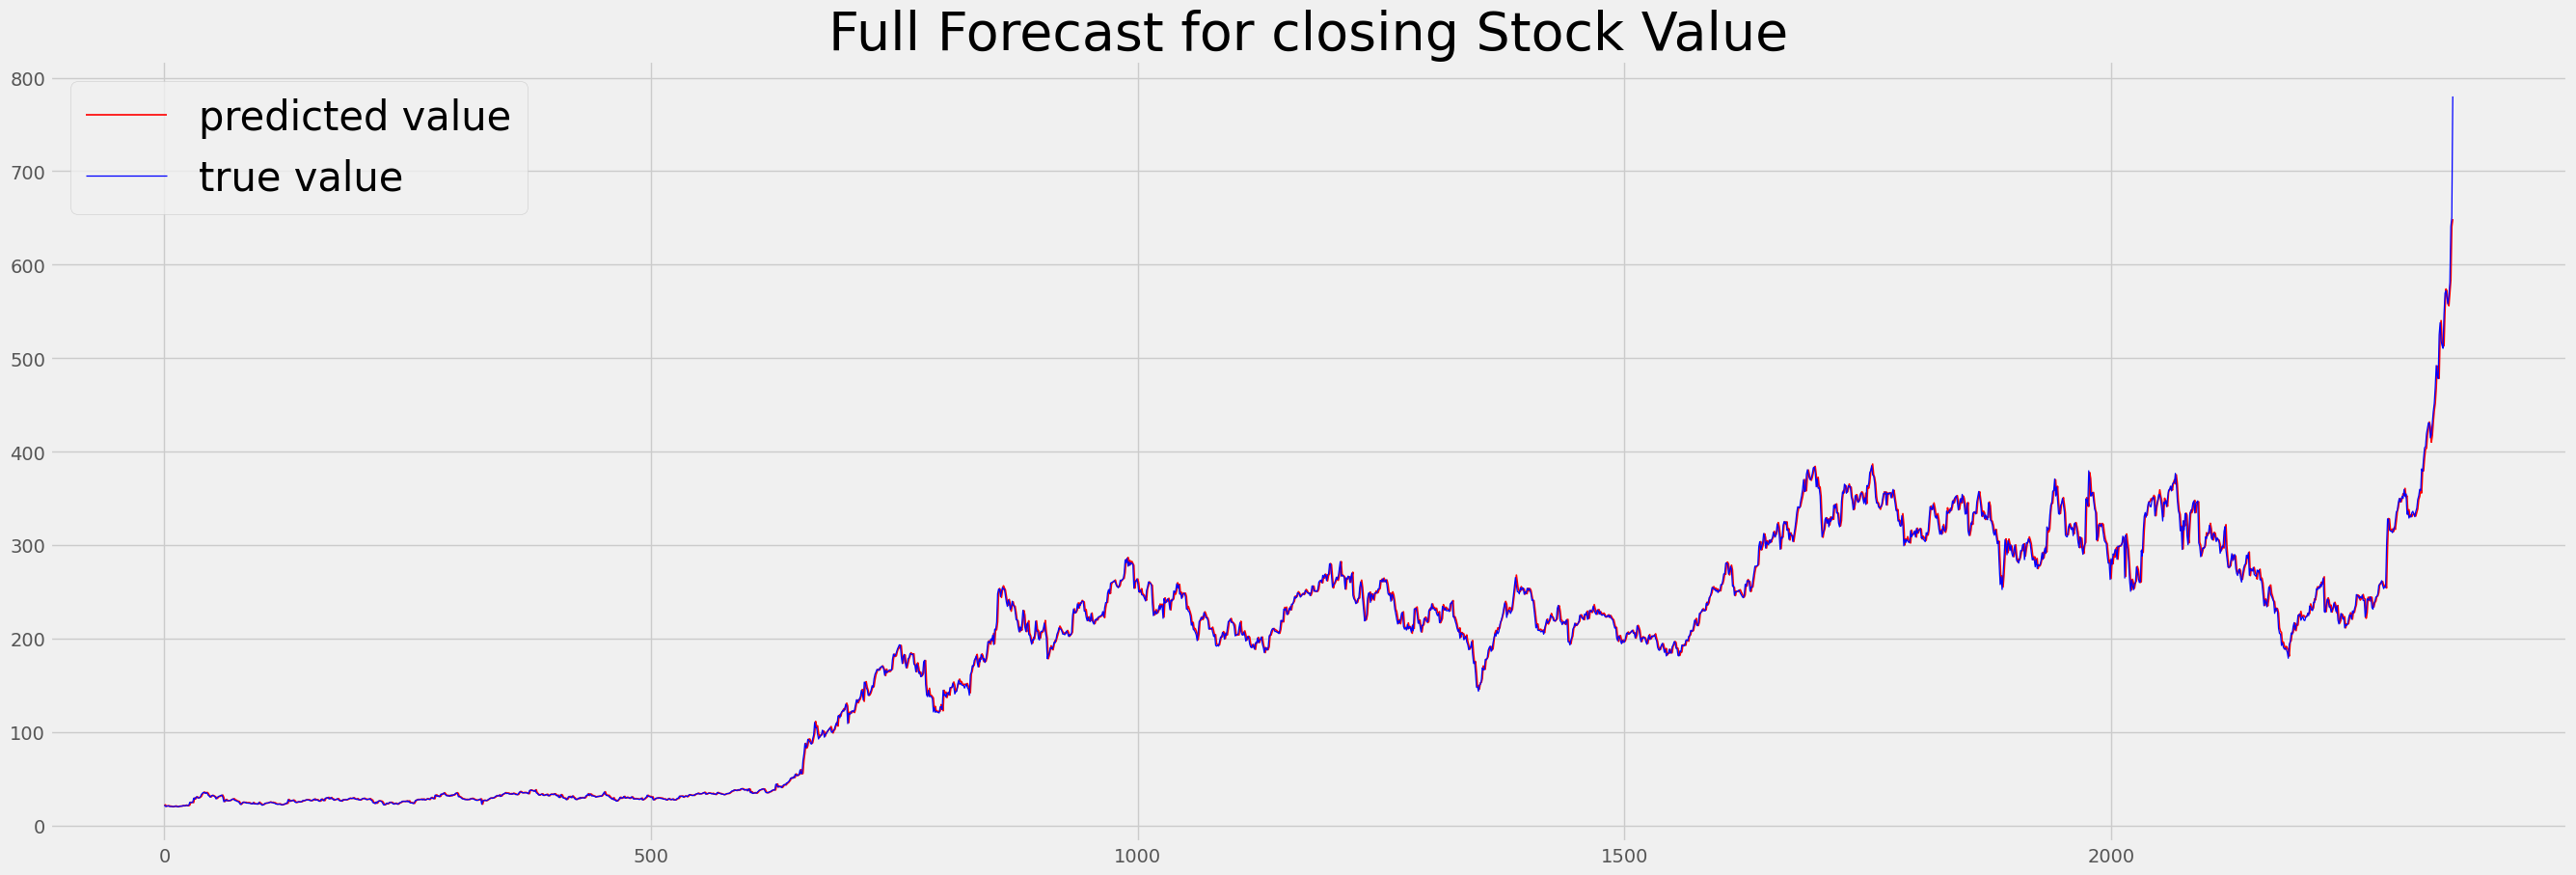

In [99]:
plt_forecast(close_preds, close_real, 'Full Forecast for closing Stock Value')